# Demonstration of warmstart grid search to compare classifier performance

An important step in classifier performance comparison is hyperparameter 
optimization. Here, we specify the classifer models we want to tune and a 
dictionary of hyperparameter ranges (preferably similar for fairness in 
comparision) for each classifier. Then, we find the optimal hyperparameters 
through a function that implements warmstart grid search and refit the optimized 
models to obtain accuracies. The performance of each hyperparameter value pairing is visualized in heatmaps.

In this example, we tune hyperparameters for two classifiers, Random Forest and Extra Trees, and compare their performance on an OpenML-CC18 benchmarking suite dataset (https://www.openml.org/d/15).  We can see clearly in the resulting plot that the optimized models perform better than or atleast similar to the default parameter models. On the dataset we use in this example, RF performs marginally better than ExtraTrees overall.


In [11]:
print(__doc__)

import pandas as pd
import numpy as np

import sklearn
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml

import matplotlib
import matplotlib.pyplot as plt

from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

Automatically created module for IPython interactive environment


In [12]:
def hyperparameter_optimization(X, y, *argv):
    """
    Given any number of classifier types and 
    a dictionary of two hyperparameters to tune for each classifier, 
    find optimal pairs of hyperparameters.

    Parameters
    ----------
    X : numpy.ndarray
        Input data, shape (n_samples, n_features)
    y : numpy.ndarray
        Output data, shape (n_samples, n_outputs)
    *argv : list of tuples (classifier, hyperparameters)
        List of (classifier, hyperparameters) tuples:

        classifier : sklearn-compliant classifier
            For example sklearn.ensemble.RandomForestRegressor
        hyperparameters : dictionary of hyperparameter values or range

    Returns
    -------
    clf_best_params : dictionary
        Dictionary of classifiers and their respective optimal hyperparameters
    """

    best_models = {}

    # Iterate over all (classifier, hyperparameter dict) pairs
    for clf, params in argv:
        best_params = grid_search(X, y, clf, params)
        best_models[clf.__class__.__name__] = best_params

    return best_models


def grid_search(X, y, clf, params):
    """
    Given a classifier and two hyperparameters and the 
    range/values to search for each, find optimal hyperparameter 
    values using warmstart grid search parameter sweeps.

    Parameters
    ----------
    X : numpy.ndarray
        Input data, shape (n_samples, n_features)
    y : numpy.ndarray
        Output data, shape (n_samples, n_outputs)
    clf : sklearn-compliant classifier
            For example sklearn.ensemble.RandomForestRegressor
    params : dictionary of hyperparameter values or range

    Returns
    -------
    best_params : dictionary
        Dictionary of best hyperparameters
    """
    param1_name = list(params.keys())[0]
    param2_name = list(params.keys())[1]
    param1 = params[param1_name]
    param2 = params[param2_name]

    # sweep over all pairs of parameter combinations
    kappa_scorer = make_scorer(cohen_kappa_score)
    mean_scores = np.zeros((np.shape(param1)[0], np.shape(param2)[0]))
    for idx1, val1 in enumerate(param1):
        clf.max_features = val1
        for idx2, val2 in enumerate(param2):
            clf.n_estimators = val2
            score = cross_val_score(clf, X, y, scoring=kappa_scorer, cv=5)
            mean_scores[idx1][idx2] = np.mean(score)

    # select parameter pair with highest kappa score
    best_idx1, best_idx2 = np.unravel_index(
        np.argmax(mean_scores, axis=None), np.shape(mean_scores)
    )
    best_params = {param1_name: param1[best_idx1], param2_name: param2[best_idx2]}

    # generate heatmap
    param_heatmap(params, mean_scores, clf.__class__.__name__)

    return best_params


def param_heatmap(params, scores, clf_name):
    """
    Given a dictionary of two parameter ranges, scores 
    for each pair of parameter values, and classifier name, 
    generate heatmap showing model performance scores for each 
    pair of parameter values.

    Parameters
    ----------
    params : dictionary of hyperparameter ranges
    scores : ndarray 
             Scores for each parameter value pair
    clf_name : string
               Name of sklearn-compliant classifier
    """
    param1_name = list(params.keys())[0]
    param2_name = list(params.keys())[1]
    param1 = params[param1_name]
    param2 = params[param2_name]

    scores = -np.array(scores)
    scores = scores.ravel().argsort().argsort().reshape(scores.shape)
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation="nearest", cmap=plt.cm.Blues)
    plt.xlabel(param2_name)
    plt.ylabel(param1_name)
    plt.colorbar()
    plt.xticks(np.arange(len(param2)), param2)
    plt.yticks(np.arange(len(param1)), param1)
    plt.title("Grid Search Kappa Rank " + clf_name)
    plt.show()

# Building classifiers and specifying parameter ranges or values to search


In [13]:
# get some data
X, y = fetch_openml(data_id=40979, return_X_y=True, as_frame=True)
y = pd.factorize(y)[0]
X = X.apply(lambda x: pd.factorize(x)[0])
n_samples, n_features = np.shape(X)

# build a classifier with warm_start=True
extraTrees = ExtraTreesClassifier(warm_start=True)

# specify parameters and ranges or values to search
extraTrees_param_dict = {
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [10, 30, 50, 70],
}

# build another classifier with warm_start=True
rf = RandomForestClassifier(warm_start=True)

# specify parameters and ranges or values to search
rf_param_dict = {
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [10, 30, 50, 70],
}

# Obtaining best parameters dictionary and refitting

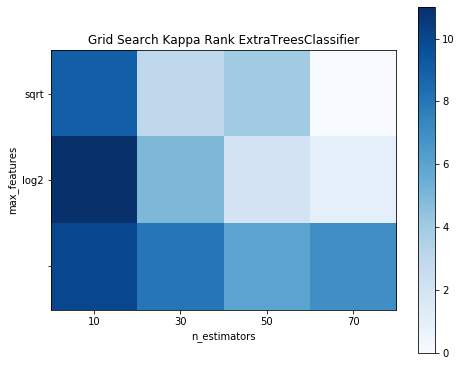

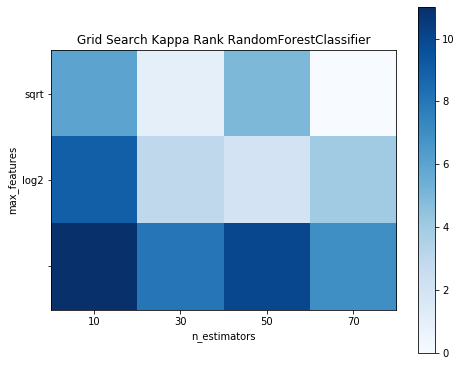

{'ExtraTreesClassifier': {'max_features': 'sqrt', 'n_estimators': 70}, 'RandomForestClassifier': {'max_features': 'sqrt', 'n_estimators': 70}}


In [14]:
tuned_params = hyperparameter_optimization(
    X, y, (extraTrees, extraTrees_param_dict), (rf, rf_param_dict)
)

print(tuned_params)

# extract values from dict - seperate each classifier's param dict
keys, values = zip(*tuned_params.items())

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [21]:
def get_accuracy(model, X_train, y_train, X_test, y_test):
    """
    Given a model, train, and test data, 
    fit model and calculate accuracy of predictions.

    Parameters
    ----------
    model : sklearn-compliant classifier
    X_train : numpy.ndarray
        Train input data, shape (n_samples, n_features)
    y_train  numpy.ndarray
        Train output data, shape (n_samples, n_outputs)
    X_test: numpy.ndarray
        Test input data, shape (n_samples, n_features)
    y_test:numpy.ndarray
        Test output data, shape (n_samples, n_outputs)

    Returns
    -------
    accuracy : float
        An sklearn metric for model performance.
    """

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    return accuracy


# get accuracies of optimized and default models
extraTrees_models = [ExtraTreesClassifier(**values[0]), ExtraTreesClassifier()]
extraTrees_acc = []
for model in extraTrees_models:
    extraTrees_acc.append(get_accuracy(model, X_train, y_train, X_test, y_test))

rf_models = [RandomForestClassifier(**values[1]), RandomForestClassifier()]
rf_acc = []
for model in rf_models:
    rf_acc.append(get_accuracy(model, X_train, y_train, X_test, y_test))

# Plotting the result

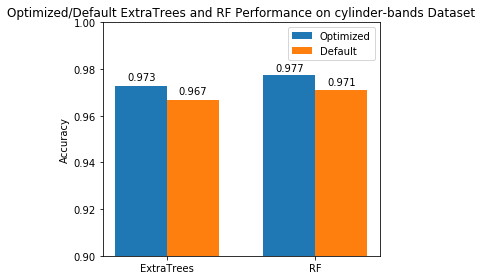

In [22]:
labels = ["ExtraTrees", "RF"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, extraTrees_acc, width, label="Optimized")
rects2 = ax.bar(x + width / 2, rf_acc, width, label="Default")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Accuracy")
ax.set_title(
    "Optimized/Default ExtraTrees and RF Performance on cylinder-bands Dataset"
)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = float("%.3f" % (rect.get_height()))
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.ylim((0.9, 1))
plt.show()